In [ ]:
# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch
import random
from PIL import ImageEnhance, ImageOps, ImageFilter
import os
import pandas as pd
from torchvision import datasets, transforms
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

### Dataset

In [ ]:
dataset = "/content/drive/MyDrive/Colab Notebooks/dataset"

dataset_file_paths = []
dataset_labels = []

for class_name in os.listdir(dataset):
    class_dir = os.path.join(dataset, class_name)
    for image_name in os.listdir(class_dir):
        dataset_file_paths.append(os.path.join(class_dir, image_name))
        dataset_labels.append(class_name)

df = pd.DataFrame({"file_path": dataset_file_paths, "label": dataset_labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Sad, Count: 250
Class: Angry, Count: 250
Class: happy, Count: 250


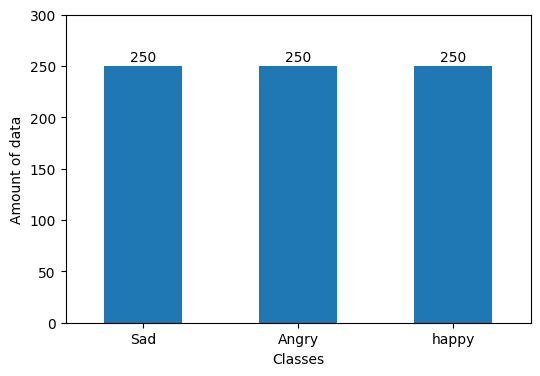

In [ ]:
class_counts_df = df['label'].value_counts()

for class_name, count in class_counts_df.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_df.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_df):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_df) * 1.2)
plt.show()

### Sample Image

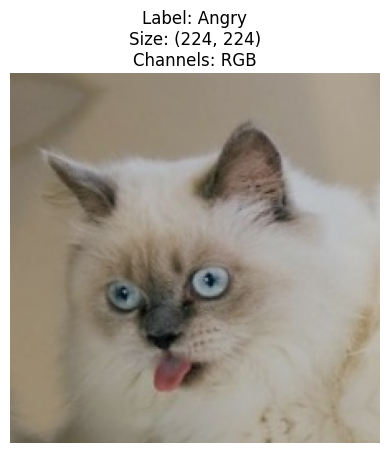

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

### Weak Augmentation

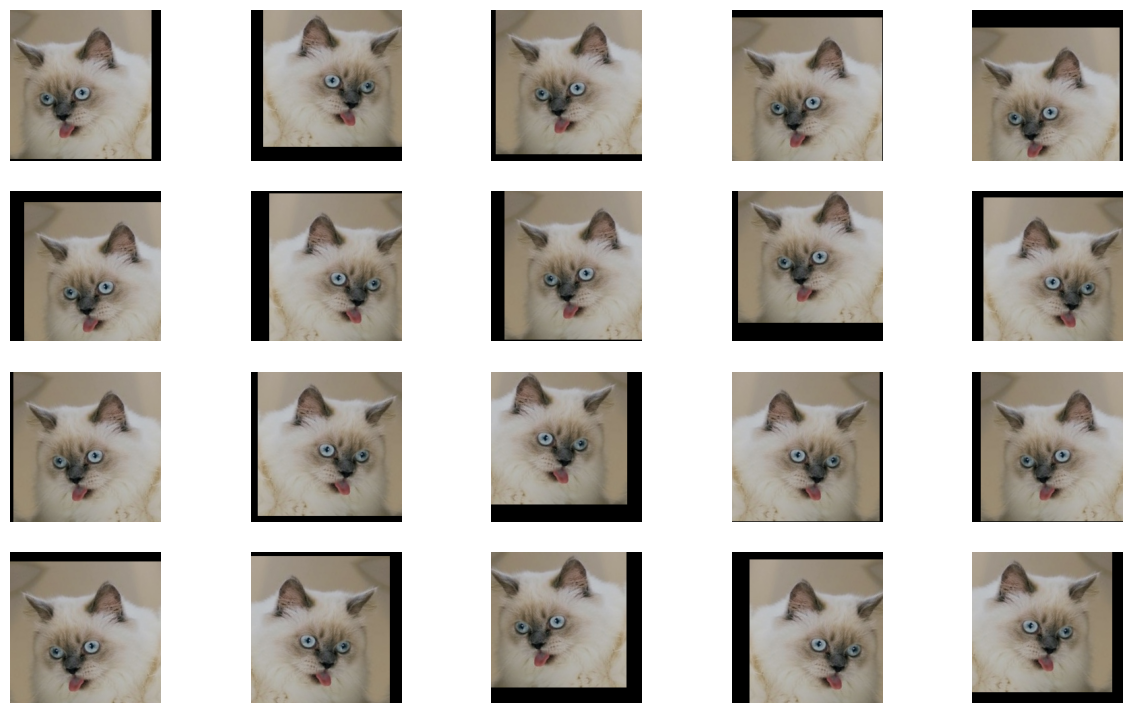

In [ ]:
weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])

image = Image.open(file_path)

weak_augmented_images = [weak_transform(image) for _ in range(20)]

fig, axes = plt.subplots(4, 5, figsize=(15, 9))

for i, ax in enumerate(axes.flat):
    ax.imshow(weak_augmented_images[i])
    ax.axis('off')

plt.show()

### Strong Augmentation

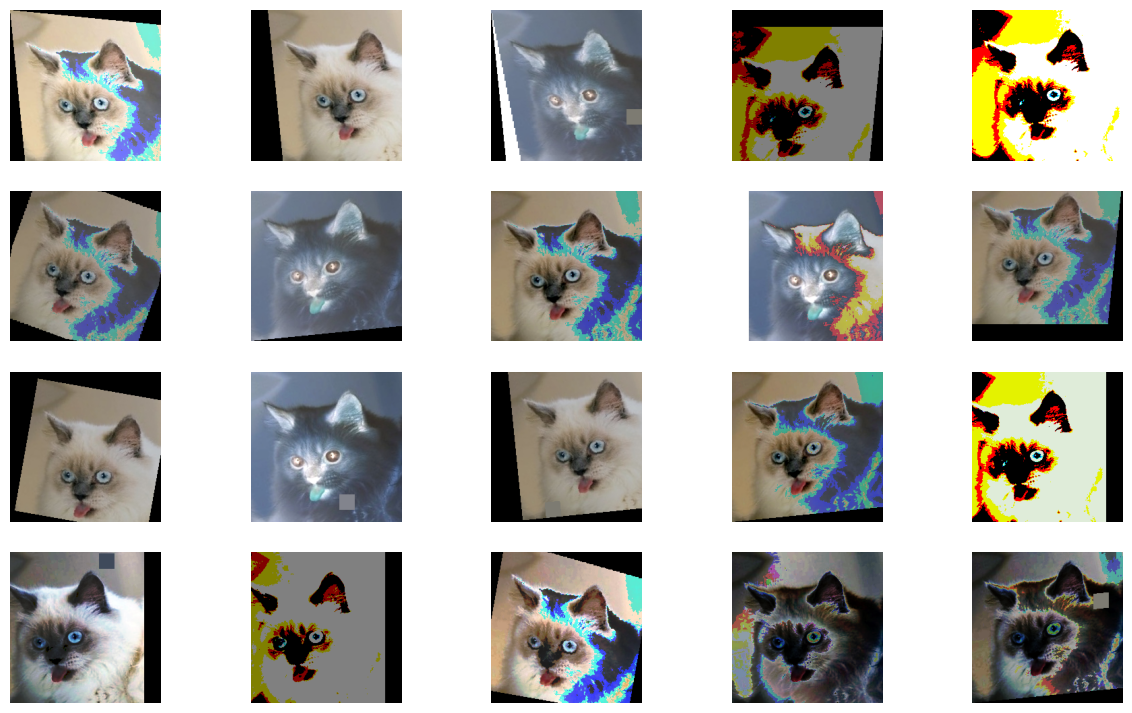

In [ ]:
def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    inverted_v = 256 - v
    return PIL.ImageOps.solarize(img, inverted_v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    enhanced_v = 1.9 - v + 0.1
    return PIL.ImageEnhance.Contrast(img).enhance(enhanced_v)

def Color(img, v):
    assert 0.1 <= v <= 1.9
    v = 1.9 - v
    return PIL.ImageEnhance.Color(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    v = 1.9 - v
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img

def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.3
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)

def Identity(img, v):
    return img

def augment_list():
    aug_list = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0.0, 0.3),
        (ShearY, 0.0, 0.3),
        (Cutout, 0, 0.3),
        (TranslateX, 0.0, 0.33),
        (TranslateY, 0.0, 0.33),
        (Identity, 0, 1)
    ]

    return aug_list

class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

strong_transform = transforms.Compose([
    RandAugment(n=4, m=10)
])

image = Image.open(file_path)

strong_augmented_images = [strong_transform(image) for _ in range(20)]

fig, axes = plt.subplots(4, 5, figsize=(15, 9))

for i, ax in enumerate(axes.flat):
    ax.imshow(strong_augmented_images[i])
    ax.axis('off')

plt.show()